In [12]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE

from aldiscore.prediction.predictor import DifficultyPredictor


In [13]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)
# feat_df.columns = clean_feat_names

print(feat_df.shape)
print(drop_df.shape)
print(label_df.shape)

Dropping 0 NaN rows...
(11431, 397)
(11431, 21)
(11431, 1)


In [4]:
# # TEST PERFORMANCE ON WITHHELD DATA
# excluded = "bali3"
# excl_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
# excl_feats = feat_df.loc[excl_idxs].copy()
# excl_labels = label_df.loc[excl_idxs].copy()
# feat_df = feat_df.drop(excl_idxs, axis=0)
# label_df = label_df.drop(excl_idxs, axis=0)
# print(feat_df.shape)
# print(drop_df.shape)
# print(label_df.shape)

In [5]:
# print("max num seqs", drop_df["num_seqs"].max())
# print("max seq len", drop_df["max:seq_length"].max())

In [3]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))
#
X_train = feat_df.loc[train_idxs]
X_test = feat_df.loc[test_idxs]
X_valid = feat_df.loc[valid_idxs]
y_train = label_df.loc[train_idxs].iloc[:, 0]
y_test = label_df.loc[test_idxs].iloc[:, 0]
y_valid = label_df.loc[valid_idxs].iloc[:, 0]

9144 1143 1144


In [42]:
param_df = pd.read_parquet(ROOT.parent / "optuna" / "trial_03.parquet")
param_df.head(5)
params = dict(param_df.drop("score", axis=1).iloc[0])
params["n_estimators"] = 250

In [43]:
param_df

,score,n_jobs,objective,metric,n_estimators,verbosity,bagging_fraction,learning_rate,subsample,colsample_bytree,feature_fraction_bynode,min_data_in_leaf,num_leaves
0,0.045414,1,regression,rmse,2000,-1,0.406860,0.029181,0.782712,0.138784,0.225888,24,39
1,0.045493,1,regression,rmse,2000,-1,0.370978,0.021477,0.621130,0.150053,0.170774,25,44
2,0.045512,1,regression,rmse,2000,-1,0.347928,0.023625,0.613847,0.129133,0.196989,24,45
3,0.045539,1,regression,rmse,2000,-1,0.366280,0.021108,0.622860,0.077859,0.449930,25,44
4,0.045539,1,regression,rmse,2000,-1,0.660120,0.023545,0.624443,0.157915,0.076476,24,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.049237,1,regression,rmse,2000,-1,0.454881,0.006701,0.720466,0.013519,0.997271,29,30
996,0.049747,1,regression,rmse,2000,-1,0.952100,0.006927,0.720156,0.014041,0.612597,22,23
997,0.049876,1,regression,rmse,2000,-1,0.936117,0.008285,0.654354,0.049080,0.052606,6,42
998,0.050471,1,regression,rmse,2000,-1,0.612303,0.010172,0.679582,0.020292,0.125858,20,28


In [44]:
import lightgbm as lgb

for key, val in params.items():
    if isinstance(params[key], float) and (float(int(val)) == val):
        params[key] = int(val)
# Train the model
model = lgb.LGBMRegressor(**params)
# model = model.fit(X_train, y_train)

In [46]:
import sklearn

# sklearn.metrics.get_scorer_names()

In [47]:
from sklearn.model_selection import cross_validate
from collections import defaultdict

results = defaultdict(list)
scoring = ["neg_root_mean_squared_error", "r2"]
for i in range(2):
    np.random.seed(i)
    idxs = np.arange(len(feat_df))
    np.random.shuffle(idxs)
    out = cross_validate(
        model,
        feat_df.iloc[idxs],
        label_df.iloc[idxs, 0],
        scoring=scoring,
        cv=7,
        n_jobs=2,
        verbose=1,
        return_train_score=True,
    )
    out = dict(filter(lambda kv: any([s in kv[0] for s in scoring]), out.items()))
    print(out)
    modes = ["train", "test"]
    for score in scoring:
        for mode in modes:
            results[(mode, score)].extend(out["_".join((mode, score))])

result_df = pd.DataFrame(results)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   7 out of   7 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


{'test_neg_root_mean_squared_error': array([-0.04461119, -0.0446631 , -0.04565752, -0.04573377, -0.04734842,
       -0.04592856, -0.04784451]), 'train_neg_root_mean_squared_error': array([-0.03142541, -0.03170847, -0.03137498, -0.03139527, -0.03136996,
       -0.03136964, -0.03117662]), 'test_r2': array([0.94097409, 0.94329445, 0.93974526, 0.93965022, 0.93193404,
       0.93615693, 0.93331837]), 'train_r2': array([0.97106424, 0.97032871, 0.97103238, 0.97098633, 0.97127303,
       0.97125889, 0.97143506])}
{'test_neg_root_mean_squared_error': array([-0.04561051, -0.04696579, -0.04834752, -0.04721563, -0.04525018,
       -0.04179965, -0.04828778]), 'train_neg_root_mean_squared_error': array([-0.03133374, -0.03151534, -0.03118533, -0.03131198, -0.03151171,
       -0.03177322, -0.03110191]), 'test_r2': array([0.94545869, 0.93609434, 0.93153133, 0.93692581, 0.93194593,
       0.94671516, 0.93017994]), 'train_r2': array([0.97059716, 0.97078432, 0.97144344, 0.97103484, 0.97140978,
       0.97

[Parallel(n_jobs=2)]: Done   7 out of   7 | elapsed:   11.0s finished


In [50]:
result_df.mean(axis=0).T.to_frame()

,,0
train,neg_root_mean_squared_error,-0.031397
test,neg_root_mean_squared_error,-0.046090
train,r2,0.971064
test,r2,0.937423


### Train production model on all available datasets

In [ ]:
model = lgb.LGBMRegressor(**params)
model = model.fit(feat_df, label_df)

In [ ]:
predictor = DifficultyPredictor(model.booster_)
predictor.save("v0.5.txt")

model = DifficultyPredictor("latest")
score = model.predict(str(ROOT / "demo" / "data" / "protein.0.fasta"), drop_gaps=True)
score

ValueError: WARNING: Found sequence with length 1

In [35]:
if isinstance(model, DifficultyPredictor):
    model = model.model
y_pred = model.predict(feat_df.loc[valid_idxs])
y_true = label_df.loc[valid_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [36]:
eps = 1e-2
perf_df = utils.compute_metrics(model, X_valid, y_valid, eps)
print(perf_df)
print()
print(np.sort(np.abs(y_pred - y_true) / (y_true + eps))[::-1][:20])

     RMSE RMSE_CV     MAE    MAPE MAPE_P50    CORR
0  0.0401  0.2746  0.0243  0.2755   0.1598  0.9747

[5.40147975 5.03094301 3.37950548 3.03623587 2.95724694 2.60927345
 2.60805133 2.31911918 2.30261827 2.14090487 2.08608681 2.07995965
 2.06566252 2.01350007 1.90891368 1.80842484 1.76064239 1.71528719
 1.65442181 1.58210367]


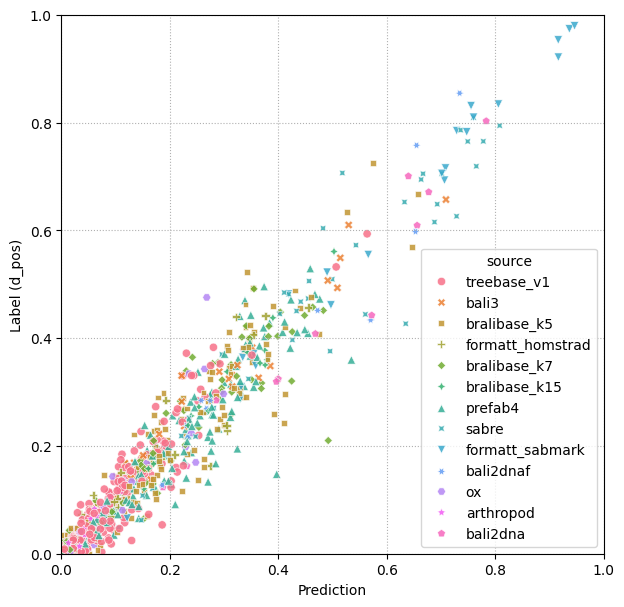

In [37]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[valid_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

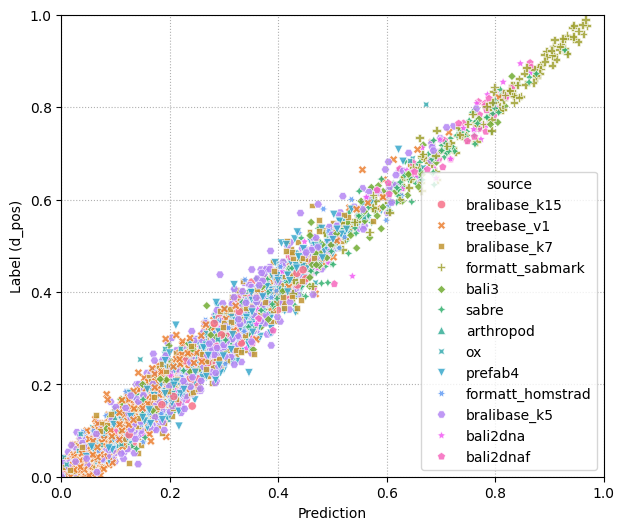

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=label_df.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

In [ ]:
test = feat_df.copy()
test["label"] = label_df["mean"]
corr = test.corr().loc["label"]
corr = corr.iloc[corr.abs().argsort()[::-1]]
corr[:20]

label                1.000000
p70.tc_base_p50     -0.885261
p70.tc_base_mean    -0.883455
p70.tc_base_min     -0.882662
mean.tc_base_p50    -0.882356
p60.tc_base_p50     -0.882130
mean.tc_base_mean   -0.881187
p60.tc_base_mean    -0.881015
mean.tc_base_max    -0.880528
p70.tc_base_max     -0.879801
mean.tc_base_min    -0.879684
p60.tc_base_max     -0.879450
p60.tc_base_min     -0.879217
p50.tc_base_p50     -0.874936
p50.tc_base_mean    -0.874196
p50.tc_base_max     -0.874180
p80.tc_base_p50     -0.872961
p50.tc_base_min     -0.872034
p80.tc_base_min     -0.871198
p80.tc_base_mean    -0.870324
Name: label, dtype: float64

In [ ]:
label_df.sort_values("mean", ascending=False).tail(40)
test_df = label_df.copy().reset_index()
test_df["iszero"] = test_df["mean"] == 0
test_df.groupby(["source"]).mean(numeric_only=True)

,mean,iszero
source,,
arthropod,0.039345,0.000000
bali2dna,0.395273,0.000000
bali2dnaf,0.397796,0.000000
bali3,0.280096,0.000000
bralibase_k15,0.116012,0.262425
bralibase_k5,0.135846,0.290229
bralibase_k7,0.128771,0.285414
formatt_homstrad,0.150750,0.033742
formatt_sabmark,0.695928,0.000000
